In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.patches import YAArrow

import numpy as np

import textwrap

from astropy.io import ascii, fits
from astropy.io.fits import getdata

In [2]:
def spectraChart():
    
    plt.style.use('fivethirtyeight')
    
    # set up figure 
    f, axs = plt.subplots(8, sharex = True, figsize=(20,45))
    f.set_facecolor('white')
    f.canvas.set_window_title("Spectra")
    
    xmin = 0.2
    xmax = 1.1
    axs[-1].set_xlim(xmin,xmax)
    axs[-1].set_xticks(np.arange(xmin, xmax, .1))
    axs[-1].set_xlabel('Wavelength ($\mu m$)', size=20)
    axs[0].set_title("Spectra",y=1.1, size=28, weight='bold')
    axs[0].text(1,26,"Brasseur,Busch,Serigano",size=10) # fragile, if plot changes, must fix
    
    for ax in axs:
        ax.yaxis.grid(False)
        ax.xaxis.grid(False)
    
    # ordering the plots (0 is the top)
    quasarPlt = 0
    galPlt = 1
    starPlt = 2
    dustPlt = 3
    solPlt = 4
    skyAbsPlt = 5
    skyEmmPlt = 6 
    sdssPlt = 7
    
    
    # Adding absorption and emission lines # SHOULD WE LABEL THESE?
    lines = [.686719,.759370, # sky absorption
             .55785, # sky emission
             .396847,.822696 #solar: Hbeta,ca+,O2
            ]
    for p in [skyAbsPlt,skyEmmPlt,sdssPlt,solPlt]:
        for l in lines:
            axs[p].axvline(l,linestyle='--',linewidth=2,color='#8b8b8b')
    
    
    # SDSS filters
    sdssU = ascii.read('u.dat') 
    sdssG = ascii.read('g.dat')
    sdssR = ascii.read('r.dat')
    sdssI = ascii.read('i.dat')
    sdssZ = ascii.read('z.dat')
    
    axs[sdssPlt].set_ylabel("SDSS Filter Response")
    
    axs[sdssPlt].plot(sdssU['col1']*10**-4,sdssU['col2'],'#008fd5',label='u')
    axs[sdssPlt].plot(sdssG['col1']*10**-4,sdssG['col2'],'#6d904f',label='g')
    axs[sdssPlt].plot(sdssR['col1']*10**-4,sdssR['col2'],'#fc4f30',label='r')
    axs[sdssPlt].plot(sdssI['col1']*10**-4,sdssI['col2'],'#a90548',label='i')
    axs[sdssPlt].plot(sdssZ['col1']*10**-4,sdssZ['col2'],'#810f7c',label='z')
    
    axs[sdssPlt].plot(sdssU['col1']*10**-4,sdssU['col4'],'#008fd5',linestyle='--',label='u')
    axs[sdssPlt].plot(sdssG['col1']*10**-4,sdssG['col4'],'#6d904f',linestyle='--',label='g')
    axs[sdssPlt].plot(sdssR['col1']*10**-4,sdssR['col4'],'#fc4f30',linestyle='--',label='r')
    axs[sdssPlt].plot(sdssI['col1']*10**-4,sdssI['col4'],'#a90548',linestyle='--',label='i')
    axs[sdssPlt].plot(sdssZ['col1']*10**-4,sdssZ['col4'],'#810f7c',linestyle='--',label='z')
    
    # adding filter labels
    for name,x,y,c in [('u',.35,.05,'#008fd5'),('g',.465,.23,'#6d904f'),('r',.615,.3,'#fc4f30'),
                       ('i',.73,.23,'#a90548'),('z',.86,.05,'#810f7c')]:
        axs[sdssPlt].annotate(name,(x,y),size=18,color=c,weight='bold')
    
    # invisible points that don't show up but allow for labeling
    axs[sdssPlt].plot([0],[0],'#8b8b8b',label='Airmass 1.3')
    axs[sdssPlt].plot([0],[0],'#8b8b8b',linestyle='--',label='No Airmass')
    
    handles, labels = axs[sdssPlt].get_legend_handles_labels()
    newLabels,newHandles = [],[]
    for handle,label in zip(handles, labels):
        if "Airmass" in label:
            newLabels.append(label)
            newHandles.append(handle)
    axs[sdssPlt].legend(newHandles, newLabels,loc='upper left')
   
    
    # Sky Spectra
    axs[skyEmmPlt].set_ylabel("Sky Emission (Flux)")
    skyEmmTab = ascii.read('SDSS_sky_emission_spectrum.csv')
    skyEmm = skyEmmTab[(skyEmmTab['lambda [Angstrom]'] >= xmin*10**4) & 
                       (skyEmmTab['lambda [Angstrom]'] <= xmax*10**4)]
    axs[skyEmmPlt].plot(skyEmm['lambda [Angstrom]']*(10**-4),
                        skyEmm['atmospheric_emission [arbitrary flux units]'],
                        color='#6d904f',label="Atmospheric Emission")
    #axs[skyEmmPlt].legend(loc='upper right')
    axs[skyEmmPlt].annotate("Atmospheric Emission",(0.91,.2),size=18,color='#6d904f',weight='bold')
    
    axs[skyAbsPlt].set_ylabel("Sky Transparency ($F_{obs}/F_{in}$)")
    skyAbsorbTab = ascii.read('sky_transparency.txt',header_start=4,data_start=6,delimiter=' ')
    skyAbsorb = skyAbsorbTab[(skyAbsorbTab['lam(A)'] >= xmin*10**4) & 
                             (skyAbsorbTab['lam(A)'] <= xmax*10**4)]
    axs[skyAbsPlt].plot(skyAbsorb['lam(A)']*(10**-4),100**((-skyAbsorb['E1.4(mag)'])/5),
                        color='#008fd5',label="Airmass = 1.4")
    #axs[skyAbsPlt].legend(loc='center right')
    axs[skyAbsPlt].annotate("Airmass = 1.4",(1,.8),size=18,color='#008fd5',weight='bold')
    
    # Interstellar Dust
    # Y-Axis in magnitude units. Spectral range in Optical.
    dust = ascii.read('IS_dust.txt',header_start=0,data_start=3,delimiter=' ')
    axs[dustPlt].set_ylabel("Dust extinction ($C_{ext}/H$)")
    #dust = dust_spec[(dust_spec['lambda'] >= 0.3) & (dust_spec['lambda'] <= 1)]
    axs[dustPlt].plot(dust['lambda'], dust['C_ext/H'],color='#6a6a6a',label='rest-frame')
    axs[dustPlt].plot(dust['lambda']*2, dust['C_ext/H'],color='#d16262',label='z = 1')
    axs[dustPlt].plot(dust['lambda']*3, dust['C_ext/H'],color='#a40606',label='z = 2')
    #axs[dustPlt].legend(loc='upper right')
    for name,x,y,c in [('rest-frame',.28,.5*10**-21,'#6a6a6a'),
                       ('z = 1',.28,1.6*10**-21,'#d16262'),('z = 2',.28,2.55*10**-21,'#a40606')]:
        axs[dustPlt].annotate(name,(x,y),size=18,color=c,weight='bold')
    
    # Galaxy Spectrum
    # Y-Axis in magnitude units. Spectral range in Optical.
    ell_spec = ascii.read('elliptical_template.ascii')
    bulge_spec = ascii.read('bulge_template.ascii')
    sa_spec = ascii.read('sa_template.ascii')
    
    axs[galPlt].set_ylabel("Galaxy Emission (Flux)")
    lambdaGalE = ell_spec['col1']*(10**-4)
    lambdaGalB = bulge_spec['col1']*(10**-4)
    lambdaGalS = sa_spec['col1']*(10**-4)
    axs[galPlt].plot(lambdaGalE,ell_spec['col2'],'#008fd5',label='Elliptical')
    axs[galPlt].plot(lambdaGalB,bulge_spec['col2'],'#6d904f',label='Bulge')
    axs[galPlt].plot(lambdaGalS,sa_spec['col2'],'#fc4f30',label='Spiral')
    axs[galPlt].legend(loc='upper right')
       
    # Stellar spectra
    axs[starPlt].set_ylabel("Stellar Emission (Flux)")
    
    b5v = ascii.read('HD003369_M0020V_B5V.txt')
    a5v = ascii.read('HD023194_M0126V_A5V.txt')
    f5v = ascii.read('HD087141_M0369V_F5V.txt')
    g5v = ascii.read('HD115617_M0468V_G5V.txt')
    k5v = ascii.read('HD156026_M0625V_K5V.txt')
    m5v = ascii.read('HD173740_M0690V_M5V.txt')

    axs[starPlt].plot(b5v['col1']*10**-4,b5v['col2'],'#810f7c',linewidth=2,label='B')
    axs[starPlt].plot(a5v['col1']*10**-4,a5v['col2'],'#008fd5',linewidth=2,label='A')
    axs[starPlt].plot(f5v['col1']*10**-4,f5v['col2'],'#6d904f',linewidth=2,label='F')
    axs[starPlt].plot(g5v['col1']*10**-4,g5v['col2'],'#e5ae38',linewidth=2,label='G')
    axs[starPlt].plot(k5v['col1']*10**-4,k5v['col2'],'#fc7730',linewidth=2,label='K')
    axs[starPlt].plot(m5v['col1']*10**-4,m5v['col2'],'#fc3330',linewidth=2,label='M')
     
    #axs[starPlt].legend(loc='upper right')
    for star,name,c,y in [(b5v,'B','#810f7c',-0.2),(a5v,'A','#008fd5',-0.1),(f5v,'F','#6d904f',0),
                   (g5v,'G','#e5ae38',0.1),(k5v,'K','#fc7730',.02),(m5v,'M','#fc3330',.02)]:
        axs[starPlt].annotate(name,(k5v['col1'][-1]*10**-4+0.005,star['col2'][-1]+y),size=18,color=c,weight='bold')
    
    # Quasar Spectra
    axs[quasarPlt].set_ylabel("Quasar Emission (Flux)")
    quasar = ascii.read('quasar.txt')
    axs[quasarPlt].plot(quasar['Wave']*10**-4,quasar['FluxD'],'#e5ae38',label='rest-frame')
    axs[quasarPlt].plot(quasar['Wave']*(10**-4)*2,quasar['FluxD'],'#e57a38',label='z = 1')
    axs[quasarPlt].plot(quasar['Wave']*(10**-4)*3,quasar['FluxD'],'#e54538',label='z = 2')
    #axs[quasarPlt].legend(loc='upper right')
    for name,x,y,c in [('rest-frame',.27,.3,'#e5ae38'),('z = 1',.23,22.5,'#e57a38'),('z = 2',.35,22.5,'#e54538')]:
        axs[quasarPlt].annotate(name,(x,y),size=18,color=c,weight='bold')
    
    # Solar Spectra
    axs[solPlt].set_ylabel("Solar Emission (Flux)")
    
    solarTab = ascii.read('ASTMG173.csv',header_start=1,data_start=2)
    solar = solarTab[(solarTab['Wvlgth nm'] >= xmin*10**3) & 
                     (solarTab['Wvlgth nm'] <= xmax*10**3)]
    axs[solPlt].plot(solar['Wvlgth nm']*10**-3,solar['Etr W*m-2*nm-1'],
                     color='#e57738',label="Airmass = 0")
    axs[solPlt].plot(solar['Wvlgth nm']*10**-3,solar['Direct+circumsolar W*m-2*nm-1'],
                     color='#e5ae38',label="Airmass = 1.5")   
    #axs[solPlt].legend(loc='upper right')
    for name,x,y,c in [('Airmass = 0',.45,2.25,'#e57738'),('Airmass = 1.5',.45,.75,'#e5ae38')]:
        axs[solPlt].annotate(name,(x,y),size=18,color=c,weight='bold')
    
    
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)   
    plt.tight_layout()    
    plt.savefig('spectra.pdf',facecolor=f.get_facecolor())
    plt.show()

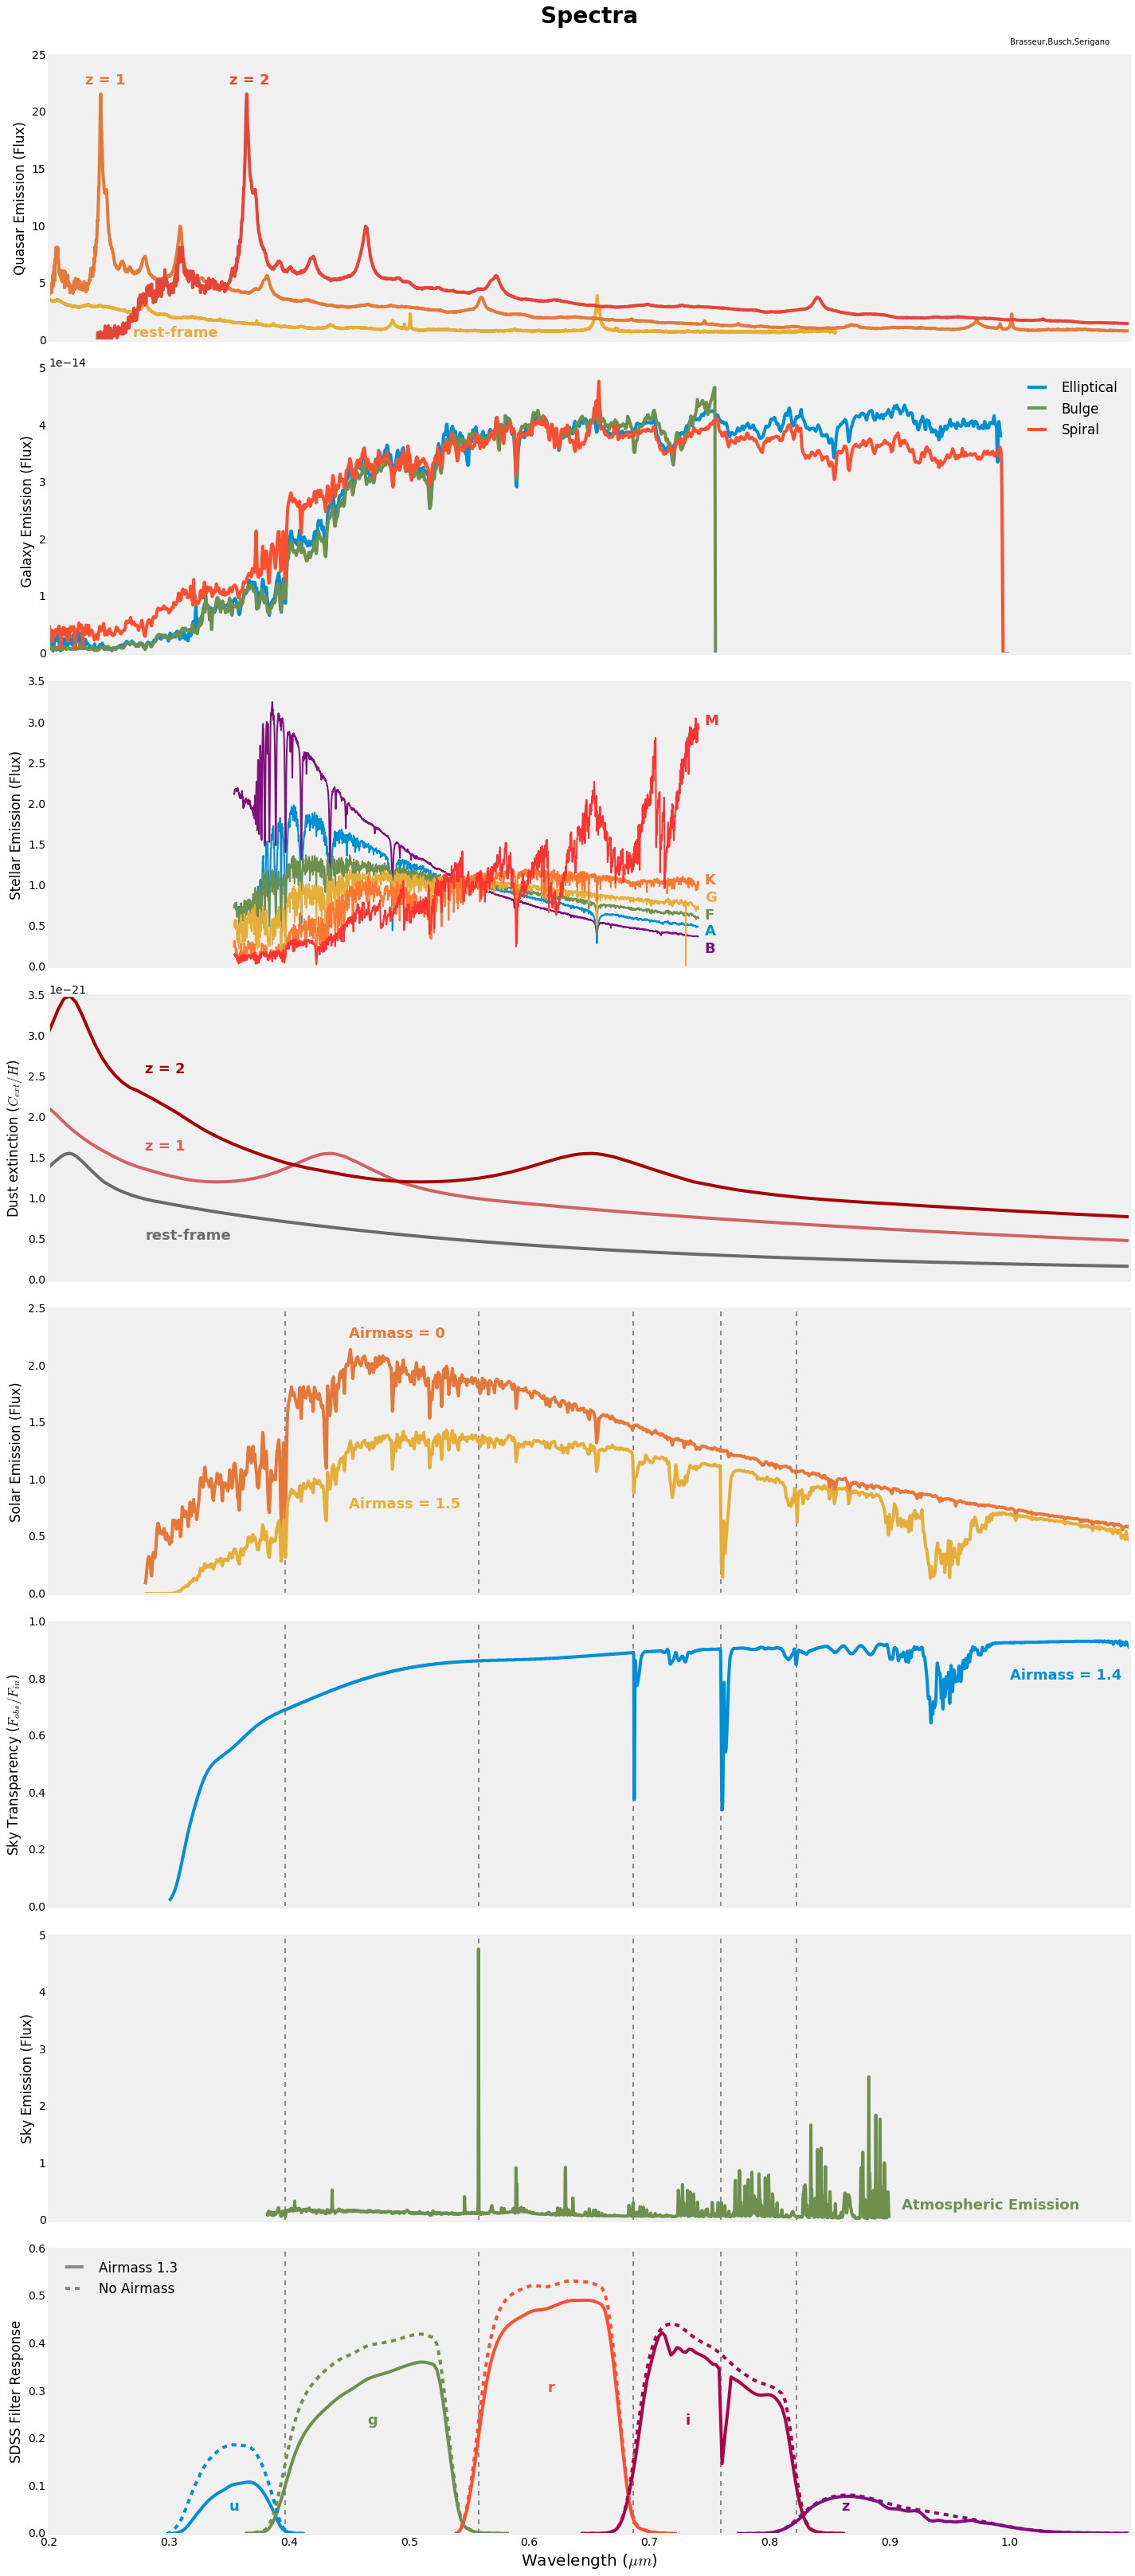

In [3]:
spectraChart()